# Создание классов датасетов российских дорожных знаков (RTSD)

In [1]:
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import warnings
warnings.filterwarnings('ignore')
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [1]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d watchman/rtsd-dataset
# !unzip rtsd-dataset.zip
# !rm rtsd-dataset.zip
# !cp -r rtsd-frames/rtsd-frames/ .
# !rm -r rtsd-frames/rtsd-frames/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### DATASET DETECT

In [4]:
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 12
classes = 2
device

'cuda:0'

# Mask RNN

In [7]:
# функция загрузки датасета minmax
def dataset_1_mask(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
    df_mask = df[['file_name', 'width', 'height', 'category_id', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name']]
    df_mask.category_id = 1
    df_mask['xmin'] = df_mask.bbox.apply(lambda x: x[0])
    df_mask['ymin'] = df_mask.bbox.apply(lambda x: x[1])
    df_mask['xmax'] = df_mask.bbox.apply(lambda x: x[0]+x[2])
    df_mask['ymax'] = df_mask.bbox.apply(lambda x: x[1]+x[3])
    df_mask = df_mask[['file_name', 'width', 'height', 'category_id', 'xmin', 'ymin', 'xmax', 'ymax', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name' ]]
    
  
  return df_mask

In [9]:
train3 = dataset_1_mask('.', 'train_anno.json')
val3 = dataset_1_mask('.', 'val_anno.json')
train3.head()

,file_name,width,height,category_id,xmin,ymin,xmax,ymax,bbox,id,image_id,area,iscrowd,name
0,rtsd-frames/autosave01_02_2012_09_13_33.jpg,1280,720,1,649,376,667,394,"[649, 376, 18, 18]",0,0,324,0,2_1
1,rtsd-frames/autosave01_02_2012_09_13_34.jpg,1280,720,1,671,356,691,377,"[671, 356, 20, 21]",1,1,420,0,2_1
2,rtsd-frames/autosave01_02_2012_09_13_35.jpg,1280,720,1,711,332,738,358,"[711, 332, 27, 26]",2,2,702,0,2_1
3,rtsd-frames/autosave01_02_2012_09_13_36.jpg,1280,720,1,764,290,801,326,"[764, 290, 37, 36]",3,3,1332,0,2_1
4,rtsd-frames/autosave01_02_2012_09_13_36.jpg,1280,720,1,684,384,701,401,"[684, 384, 17, 17]",4,3,289,0,1_23


In [ ]:
# class PennFudanDataset(torch.utils.data.Dataset):
#     def __init__(self, root, transforms):
#         self.root = root
#         self.transforms = transforms
#         # load all image files, sorting them to
#         # ensure that they are aligned
#         self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
#         self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

#     def __getitem__(self, idx):
#         # load images and masks
#         img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
#         mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
#         img = Image.open(img_path).convert("RGB")
#         # note that we haven't converted the mask to RGB,
#         # because each color corresponds to a different instance
#         # with 0 being background
#         mask = Image.open(mask_path)
#         # convert the PIL Image into a numpy array
#         mask = np.array(mask)
#         # instances are encoded as different colors
#         obj_ids = np.unique(mask)
#         # first id is the background, so remove it
#         obj_ids = obj_ids[1:]

#         # split the color-encoded mask into a set
#         # of binary masks
#         masks = mask == obj_ids[:, None, None]

#         # get bounding box coordinates for each mask
#         num_objs = len(obj_ids)
#         boxes = []
#         for i in range(num_objs):
#             pos = np.where(masks[i])
#             xmin = np.min(pos[1])
#             xmax = np.max(pos[1])
#             ymin = np.min(pos[0])
#             ymax = np.max(pos[0])
#             boxes.append([xmin, ymin, xmax, ymax])

#         # convert everything into a torch.Tensor
#         boxes = torch.as_tensor(boxes, dtype=torch.float32)
#         # there is only one class
#         labels = torch.ones((num_objs,), dtype=torch.int64)
#         masks = torch.as_tensor(masks, dtype=torch.uint8)

#         image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         # suppose all instances are not crowd
#         iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = labels
#         target["masks"] = masks
#         target["image_id"] = image_id
#         target["area"] = area
#         target["iscrowd"] = iscrowd

#         if self.transforms is not None:
#             img, target = self.transforms(img, target)

#         return img, target

#     def __len__(self):
#         return len(self.imgs)

In [10]:
class RTSD_dataset_my_m(Dataset):
    def __init__(self, path_img, df, transforms=None):
        super().__init__()
        self.path_img = path_img
        self.transforms = transforms
        self.df = df
#         self.df = self.df.groupby('file_name', as_index=False).agg(list)
        
    def __getitem__(self, index):
        name_img = self.df.loc[index,'file_name']
        img = Image.open(os.path.join(self.path_img, name_img))
        
#         def create_bb_array(x):
#             """Генерируем массив bounding box'a из столбца train_df"""
#             return np.array([x[5],x[4],x[7],x[6]])
        
        
        img = img.resize((720, 1280))
        
        
        image_width = self.df.loc[index,'width'] #img.shape[1]
        image_height = self.df.loc[index,'height'] #img.shape[0]
        
        xmin = (self.df.loc[index][4]/image_width)*1280
        xmax = (self.df.loc[index][6]/image_width)*1280
        ymin = (self.df.loc[index][5]/image_height)*720
        ymax = (self.df.loc[index][7]/image_height)*720
        
        bb = np.array([int(ymin), int(xmin), int(ymax), int(xmax)])
              
        
        def create_mask(bb):
            """Создаем маску для bounding box'a такого же шейпа как и изображение"""
            rows,cols = 720, 1280
            Y = np.zeros((rows, cols))
            bb = bb.astype(np.int)
            Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
            return Y


        def mask_to_bb(Y):
            """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
            cols, rows = np.nonzero(Y)
            if len(cols) == 0: 
                return np.zeros(4, dtype=np.float32)
            top_row = np.min(rows)
            left_col = np.min(cols)
            bottom_row = np.max(rows)
            right_col = np.max(cols)
            return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

        mask = create_mask(bb)
        
        
        obj_ids = np.unique(mask)
        
        # Number of Bounding Boxes
#         obj_ids = np.array(list(range(len(boxes))))
        obj_ids = obj_ids[1:]
        ## Split mask into seperate mask
        masks = mask == obj_ids[:, None,None]

        masks = torch.as_tensor(masks, dtype=torch.uint8)
    
        boxes = []
        boxes.append(mask_to_bb(mask))
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones(1, dtype=torch.int64)
        img_id = torch.tensor([self.df.loc[index, 'image_id']])

#         areas = torch.as_tensor(self.df.loc[index,'area'], dtype=torch.float32)
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros(1).to(torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["masks"] = masks
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
        

        img = img / 255

        return img, my_annotation

    def __len__(self):
        
        return self.df.shape[0]

In [5]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

In [11]:
df3 = RTSD_dataset_my_m('./', train3, transforms=get_transform())
df33 = RTSD_dataset_my_m('./', val3, transforms=get_transform())

In [12]:
data_loader_train3 = torch.utils.data.DataLoader(df3,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_val3 = torch.utils.data.DataLoader(df33,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          drop_last = True)

In [13]:
len(df3)

95492

In [14]:
df3.__getitem__(968)

(tensor([[[1.2303e-04, 1.6917e-04, 2.1530e-04,  ..., 9.5348e-04,
           1.0458e-03, 1.3072e-03],
          [1.2303e-04, 1.6917e-04, 2.1530e-04,  ..., 9.3810e-04,
           1.4302e-03, 1.7070e-03],
          [1.2303e-04, 1.5379e-04, 1.9992e-04,  ..., 9.6886e-04,
           2.1838e-03, 2.4298e-03],
          ...,
          [3.0757e-05, 3.0757e-05, 3.0757e-05,  ..., 6.3053e-04,
           5.8439e-04, 4.9212e-04],
          [1.5379e-05, 1.5379e-05, 1.5379e-05,  ..., 1.8454e-04,
           1.8454e-04, 1.5379e-04],
          [1.5379e-05, 1.5379e-05, 1.5379e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[4.3060e-04, 4.7674e-04, 5.0750e-04,  ..., 9.6886e-04,
           1.0458e-03, 1.3072e-03],
          [4.3060e-04, 4.6136e-04, 5.0750e-04,  ..., 9.5348e-04,
           1.4302e-03, 1.7070e-03],
          [4.3060e-04, 4.4598e-04, 4.9212e-04,  ..., 9.8424e-04,
           2.1992e-03, 2.4298e-03],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.612

In [15]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [16]:
model = get_model_instance_segmentation(2).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 102MB/s]


In [ ]:
images,targets = next(iter(data_loader_train3))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
output = model(images,targets)   

In [ ]:
output

{'loss_classifier': tensor(0.9984, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0020, grad_fn=<DivBackward0>),
 'loss_mask': tensor(1.4168, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.1257, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0023, grad_fn=<DivBackward0>)}

In [ ]:
loss1_train = []
loss1_val = []

for epoch in range(n_epochs):
    start = time.time()
    model.train()
    for i, batch in enumerate(data_loader_train3):
        optimizer.zero_grad()
        loss_train = 0
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         try:
        loss_dict = model(imgs, targets)
#         except:
#             print(batch)
#         else:
        losses = sum(loss for loss in loss_dict.values())
        loss_train += losses.item()
        losses.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {losses.item()}')
    
    loss11_train = (loss_train / i)
    loss1_train.append(loss11_train)
    
    print('Эпоха train:', epoch,'Итераций:', i, 'train loss:', (loss_train / i))
    
    for i, batch in enumerate(data_loader_val3):
        optimizer.zero_grad()
        loss_val = 0
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
              loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_val += losses.item()
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {losses.item()}')
    
    loss11_val = (loss_val / i)
    loss1_val.append(loss11_val)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

    end = time.time()
    print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
    print('Эпоха val:', epoch, 'Итераций:', i, 'val loss:', (loss_val / i))
    
        
    torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'loss_train': loss1_train,
                    'loss_val': loss1_val,
                    }, f'./chkpt_model3_d_{epoch}.pth')
    
    torch.save(model.state_dict(), f'./chkpt_m3_d_{epoch}.pth')

epoch: 0, step: 0, loss: 0.9116367101669312
epoch: 0, step: 200, loss: 0.3091042637825012
epoch: 0, step: 400, loss: 26.220123291015625
epoch: 0, step: 600, loss: 49.15089797973633
epoch: 0, step: 800, loss: 35.286895751953125
epoch: 0, step: 1000, loss: 451.1973571777344
epoch: 0, step: 1200, loss: 53048.8046875
epoch: 0, step: 1400, loss: 1119.857421875
epoch: 0, step: 1600, loss: 114.10011291503906
epoch: 0, step: 1800, loss: 118877.203125
epoch: 0, step: 2000, loss: 0.39057427644729614
epoch: 0, step: 2200, loss: 0.3609306216239929
epoch: 0, step: 2400, loss: 0.317417711019516
epoch: 0, step: 2600, loss: 0.3197692036628723
epoch: 0, step: 2800, loss: 0.30734506249427795
epoch: 0, step: 3000, loss: 0.29751622676849365
epoch: 0, step: 3200, loss: 0.23442599177360535
epoch: 0, step: 3400, loss: 0.23490169644355774
epoch: 0, step: 3600, loss: 0.17649583518505096
epoch: 0, step: 3800, loss: 0.18605004251003265
epoch: 0, step: 4000, loss: 0.2401772141456604
epoch: 0, step: 4200, loss: 0.

#### Визуализация данных (Аргументация)

In [ ]:
# mask
def show_tranformed_image0(train_loader):
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    if len(train_loader) > 0:
        for i in range(1):
            _, targets = next(iter(train_loader))
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            boxes = targets[i]['masks']#.cpu().numpy().astype(np.int32)
            for box in boxes:
                plt.imshow(box, cmap='gray')
                plt.show()

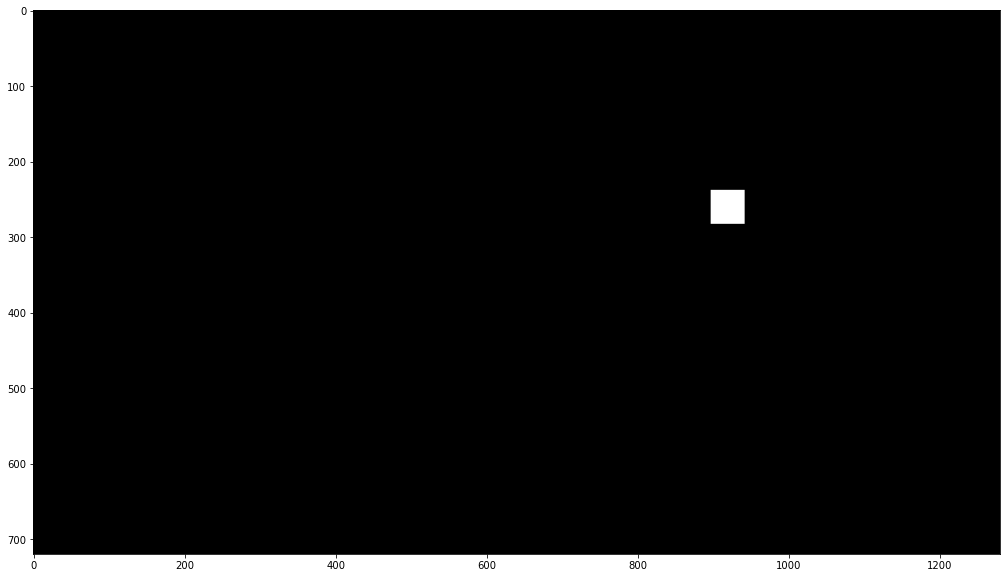

In [ ]:
%matplotlib inline
show_tranformed_image0(data_loader_train3)